# Инициализация

Загружаем библиотеки необходимые для выполнения кода ноутбука.

In [2]:
import logging
import boto3
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
from dotenv import load_dotenv

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
%config InlineBackend.figure_format = 'retina'

In [4]:
load_dotenv()

True

In [5]:
from botocore.client import Config
from botocore.exceptions import ClientError

AWS_ACCESS_KEY_ID = os.getenv("AWS_ACCESS_KEY_ID")
AWS_SECRET_ACCESS_KEY = os.getenv("AWS_SECRET_ACCESS_KEY")
S3_BUCKET_NAME = os.getenv("S3_BUCKET_NAME")
endpoint_url = 'https://storage.yandexcloud.net' 
s3 = boto3.client('s3',
    aws_access_key_id=AWS_ACCESS_KEY_ID,
    aws_secret_access_key=AWS_SECRET_ACCESS_KEY,
    endpoint_url=endpoint_url,
    config=Config(signature_version='s3v4', s3={'payload_signing_enabled': False})
)

# === ЭТАП 1 ===

# Загрузка первичных данных

Загружаем первичные данные из файлов:
- tracks.parquet
- catalog_names.parquet
- interactions.parquet

In [3]:
tracks = pd.read_parquet('tracks.parquet')
catalog_names = pd.read_parquet('catalog_names.parquet')
interactions = pd.read_parquet('interactions.parquet')

In [10]:
unic_genre = tracks['genres'].explode().unique()
unic_genre = np.sort(unic_genre)
print(unic_genre)
print(len(unic_genre))

[1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27
 28 29 30 31 32 33 35 37 38 39 40 41 43 44 45 47 48 49 50 51 52 53 54 55
 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79
 80 81 82 83 84 85 86 87 88 90 93 94 97 98 101 109 110 nan 89 91 92 95 99
 102 104 105 106 107 108 111 112 113 114 115 116 117 118 120 121 122 123
 124 126 127 128 130 131 132 133 134 135 138 146 148 150 151 152 153 154
 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 190 227 246
 300 308 319 325 332 335 383 415 432 489 610 702 703 743 762 849 923 1016
 1182 1197 1484 1542]
174


# Обзор данных

Проверяем данные, есть ли с ними явные проблемы.

In [68]:
catalog_names[(catalog_names['id'] == 170) & (catalog_names['type'] == 'genre')]

,id,type,name


In [ ]:
interactions.sort_values(by='user_id', ascending=True)

,user_id,track_id,track_seq,started_at
0,0,99262,1,2022-07-17
5,0,590803,6,2022-07-25
6,0,597196,7,2022-07-25
7,0,597199,8,2022-07-25
16,0,14370719,17,2022-08-28
...,...,...,...,...
59,1374582,39668031,60,2022-11-18
26,1374582,27389325,27,2022-11-10
4,1374582,2192958,5,2022-11-07
160,1374582,68566799,161,2022-12-07


# Выводы

Приведём выводы по первому знакомству с данными:
- есть ли с данными явные проблемы,
- какие корректирующие действия (в целом) были предприняты.

In [5]:
def get_name_catalog(df, id, type):
    try:
        res = df.query('id == @id and type == @type')
        return res['name']
    except:
        return None

# === ЭТАП 2 ===

# EDA

Распределение количества прослушанных треков.

In [23]:
interactions_track_count = interactions.groupby('track_id').agg(count=('user_id', 'count')).reset_index()

/home/mle-user/mle_projects/mle-project-sprint-4-v001/env_recsys_start/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


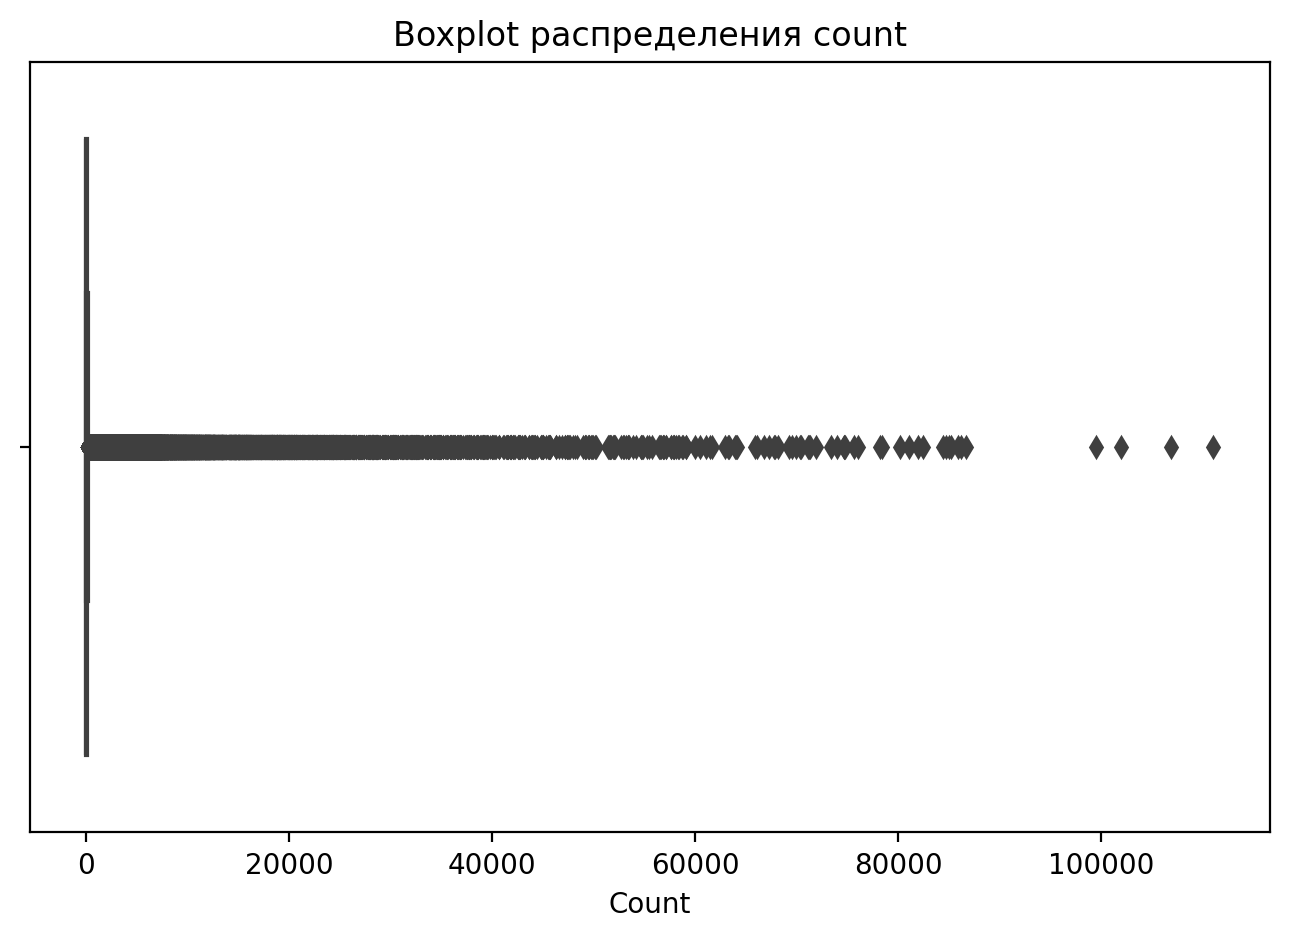

In [ ]:

plt.figure(figsize=(8, 5))
sns.boxplot(x=interactions_track_count['count'])
plt.title('Boxplot распределения count')
plt.xlabel('Count')
plt.show()

Наиболее популярные треки

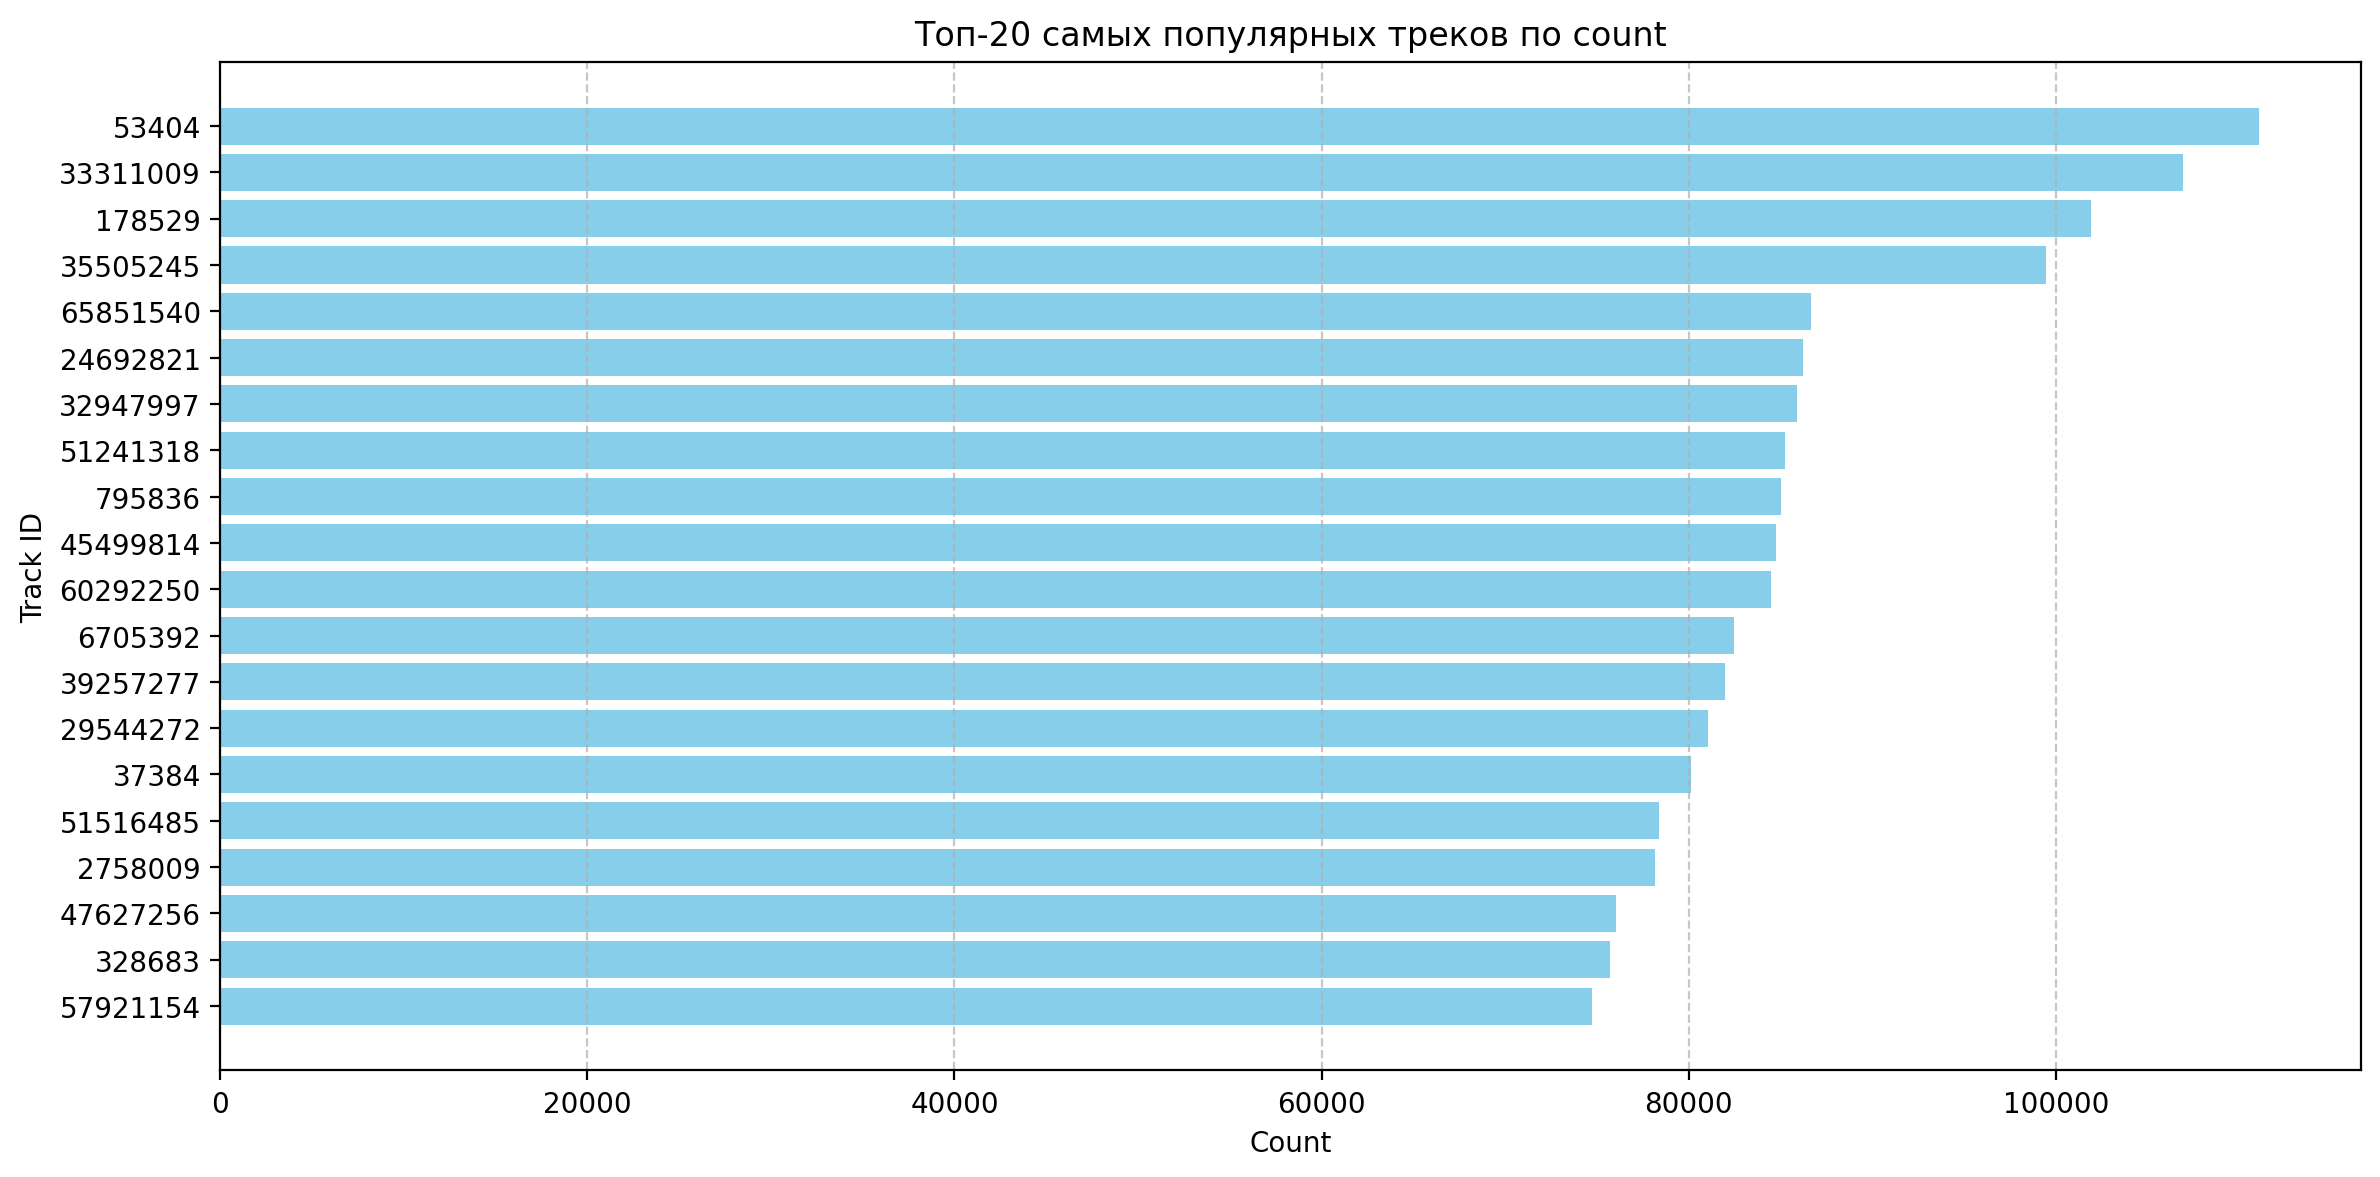

In [25]:
top_n = 20
top_tracks = interactions_track_count.sort_values(by=['count'], ascending=False).head(top_n)
# Строим график
plt.figure(figsize=(12, 6))
plt.barh(top_tracks['track_id'].astype(str), top_tracks['count'], color='skyblue')
plt.xlabel('Count')
plt.ylabel('Track ID')
plt.title(f'Топ-{top_n} самых популярных треков по count')
plt.gca().invert_yaxis()  # Самый популярный сверху
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Наиболее популярные жанры

In [46]:

genre_tracks = tracks[['track_id', 'genres']].explode('genres')
genre_count = genre_tracks.groupby('genres').agg(count=('track_id', 'count'))


genre_counts = genre_count.reset_index().rename(columns={'genres': 'genre_id'})
genre_counts = genre_counts.sort_values('count', ascending=False)

genre_counts

,genre_id,count
10,11,166285
70,75,128212
95,102,118509
63,68,114245
42,47,72311
...,...,...
100,108,14
98,106,4
127,148,4
115,124,2


In [61]:
# catalog_names: id → name
genres_only = catalog_names[catalog_names['type'] == 'genre'][['id', 'name']].rename(columns={'id': 'genre_id'})
genre_counts_named = genre_counts.merge(genres_only, on='genre_id', how='left')

In [60]:
nan_index = genre_counts_named[genre_counts_named['name'].isna()].index
nan_index

Index([ 33,  39,  47,  53,  58,  64,  72,  80,  82,  85,  94, 106, 112, 114,
       119, 126, 129, 130, 139, 141, 148, 151, 152, 153, 162, 164, 167, 170,
       171, 172],
      dtype='int64')

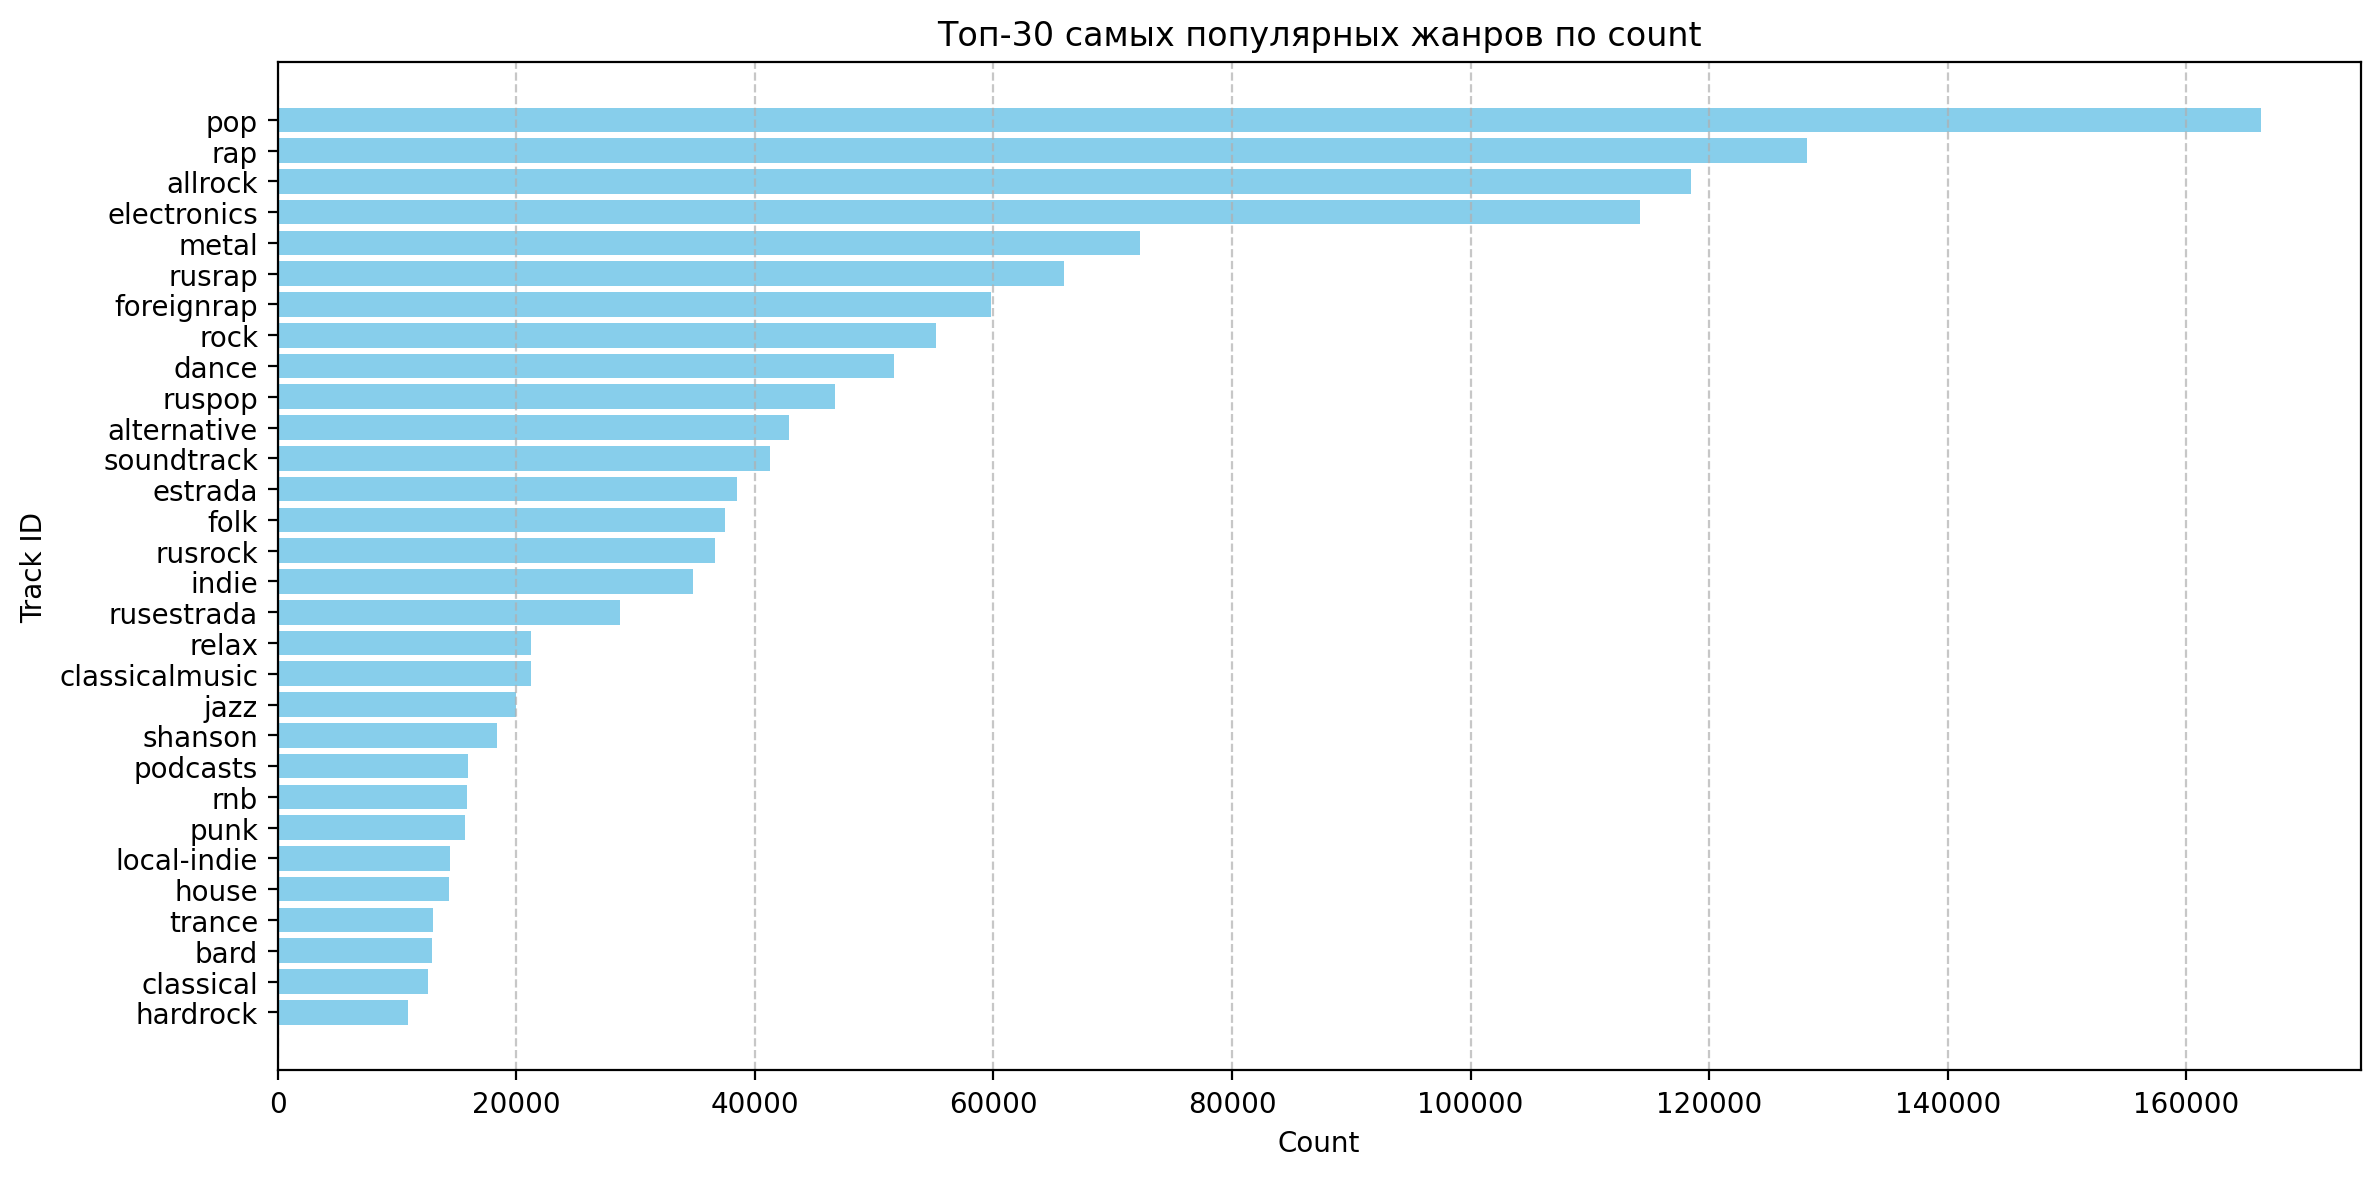

In [58]:
top_n = 30
top_genre = genre_counts_named.sort_values(by=['count'], ascending=False).head(top_n)
# Строим график
plt.figure(figsize=(12, 6))
plt.barh(top_genre['name'].astype(str), top_genre['count'], color='skyblue')
plt.xlabel('Count')
plt.ylabel('Track ID')
plt.title(f'Топ-{top_n} самых популярных жанров по count')
plt.gca().invert_yaxis()  # Самый популярный сверху
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Треки, которые никто не прослушал

In [48]:
# 1. Получаем уникальные прослушанные треки
played_tracks = interactions['track_id'].unique()

# 2. Отбираем треки, которых не было в прослушиваниях
unplayed_tracks = tracks[~tracks['track_id'].isin(played_tracks)]
unplayed_tracks

,track_id,albums,artists,genres


# Преобразование данных

Преобразуем данные в формат, более пригодный для дальнейшего использования в расчётах рекомендаций.

In [ ]:
items = tracks.copy()
events = interactions.copy()

events['user_id'] = pd.factorize(events['user_id'])[0] + 1_000_000
events.rename(columns={'track_id': 'item_id'}, inplace=True)
items.rename(columns={'track_id': 'item_id'}, inplace=True)

In [66]:
del tracks
del interactions

In [65]:
events

,user_id,item_id,track_seq,started_at
0,1000000,99262,1,2022-07-17
1,1000000,589498,2,2022-07-19
2,1000000,590262,3,2022-07-21
3,1000000,590303,4,2022-07-22
4,1000000,590692,5,2022-07-22
...,...,...,...,...
287,2373220,95514767,288,2022-12-29
288,2373220,97220301,289,2022-12-29
289,2373220,97241171,290,2022-12-29
290,2373220,98542641,291,2022-12-29


# Сохранение данных

Сохраним данные в двух файлах в персональном S3-бакете по пути `recsys/data/`:
- `items.parquet` — все данные о музыкальных треках,
- `events.parquet` — все данные о взаимодействиях.

In [ ]:
items.to_parquet("items.par")
events.to_parquet("events.par")

In [ ]:
s3_path = '/resurse/data/'
local_file_1 = 'items.par'
local_file_2 = 'events.par'

s3.upload_file(local_file_1, S3_BUCKET_NAME, s3_path + local_file_1)
s3.upload_file(local_file_2, S3_BUCKET_NAME, s3_path + local_file_2)

print("Файл успешно отправлен!")

Файл успешно отправлен!


In [37]:
key = 'resurse/data/events.par'

try:
    s3.head_object(Bucket=S3_BUCKET_NAME, Key=key)
    print(f"✅ Файл найден в S3: s3://{S3_BUCKET_NAME}/{key}")
except ClientError as e:
    if e.response['Error']['Code'] == "404":
        print("❌ Файл не найден на S3.")
    else:
        print(f"⚠️ Ошибка при доступе к файлу: {e}")

✅ Файл найден в S3: s3://s3-student-mle-20250424-775513bdf8/resurse/data/events.par


# Очистка памяти

Здесь, может понадобится очистка памяти для высвобождения ресурсов для выполнения кода ниже. 

Приведите соответствующие код, комментарии, например:
- код для удаление более ненужных переменных,
- комментарий, что следует перезапустить kernel, выполнить такие-то начальные секции и продолжить с этапа 3.

In [ ]:
del interactions_track_count

# === ЭТАП 3 ===

# Загрузка данных

Если необходимо, то загружаем items.parquet, events.parquet.

In [6]:
items = pd.read_parquet("items.par")
events = pd.read_parquet("events.par")
catalog_names = pd.read_parquet('catalog_names.parquet')


# Разбиение данных

Разбиваем данные на тренировочную, тестовую выборки.

In [7]:
events.info()

<class 'pandas.core.frame.DataFrame'>
Index: 222629898 entries, 0 to 291
Data columns (total 4 columns):
 #   Column      Dtype         
---  ------      -----         
 0   user_id     int64         
 1   item_id     int32         
 2   track_seq   int16         
 3   started_at  datetime64[ns]
dtypes: datetime64[ns](1), int16(1), int32(1), int64(1)
memory usage: 6.2 GB


In [8]:
# зададим точку разбиения
train_test_global_time_split_date = pd.to_datetime("2022-12-16")

train_test_global_time_split_idx = events["started_at"] < train_test_global_time_split_date
events_train = events[train_test_global_time_split_idx]
events_test = events[~train_test_global_time_split_idx]

# количество пользователей в train и test
users_train = events_train["user_id"].drop_duplicates()
users_test = events_test["user_id"].drop_duplicates()
# количество пользователей, которые есть и в train, и в test
common_users =  set(users_train) & set(users_test)

print(len(users_train), len(users_test), len(common_users))

1342566 783525 752870


In [7]:
# множества пользователей в train и test
set_train = set(users_train)
set_test = set(users_test)

# "холодные" пользователи — в test, но нет в train
cold_users_ids = set_test - set_train

# преобразуем в DataFrame, если нужно
cold_users = pd.DataFrame({'user_id': list(cold_users_ids)})

print(f'Число холодных пользователей: {len(cold_users)}')

Число холодных пользователей: 30655


# Топ популярных

Рассчитаем рекомендации как топ популярных.

In [9]:
from sklearn.preprocessing import MinMaxScaler

item_popularity = events_train.groupby(["item_id"]).agg(users=("user_id", "nunique"), avg_track_seq=("track_seq", "mean")).reset_index()
scaler = MinMaxScaler()
item_popularity[["users_norm"]] = scaler.fit_transform(
    item_popularity[["users"]]
)


# сортируем по убыванию popularity_score
item_popularity = item_popularity.sort_values(by='users_norm', ascending=False)# ваш код здесь #

# выбираем первые 100 айтемов со средней оценкой avg_rating не меньше 4
top_k_pop_items = item_popularity.head(100)
top_k_pop_items

,item_id,users,avg_track_seq,users_norm
9098,53404,110026,17.389681,1.000000
483876,33311009,101076,225.144396,0.918655
26665,178529,100866,38.155781,0.916746
512157,35505245,95523,155.747914,0.868185
368072,24692821,84153,185.660666,0.764844
...,...,...,...,...
849893,68562711,47588,312.812684,0.432511
904051,75944934,47536,431.932641,0.432038
902657,75642961,47438,341.175935,0.431147
423054,29175370,47320,135.490997,0.430075


In [12]:
get_name_catalog(catalog_names, 53404, 'track')

821569    Smells Like Teen Spirit
Name: name, dtype: object

# Персональные

# НИЖЕ КОД ПОСТОЯННО КРАШИТ ВМ ИЛИ KERNEL
Из-за этого я не могу продолжать разработку, вм будто не справляется с количеством данных пробовал ALS и surprise

Рассчитаем персональные рекомендации.

In [9]:
import scipy
import sklearn.preprocessing

# перекодируем идентификаторы пользователей: 
# из имеющихся в последовательность 0, 1, 2, ...
user_encoder = sklearn.preprocessing.LabelEncoder()
user_encoder.fit(events["user_id"])
events_train["user_id_enc"] = user_encoder.transform(events_train["user_id"])
events_test["user_id_enc"] = user_encoder.transform(events_test["user_id"])

# перекодируем идентификаторы объектов: 
# из имеющихся в последовательность 0, 1, 2, ...
item_encoder = sklearn.preprocessing.LabelEncoder()
item_encoder.fit(items["item_id"])
items["item_id_enc"] = item_encoder.transform(items["item_id"])
events_train["item_id_enc"] = item_encoder.transform(events_train["item_id"])
events_test["item_id_enc"] = item_encoder.transform(events_test["item_id"])
srt = sorted(events_train['item_id_enc'], reverse=True)
srt[:5]

/tmp/ipykernel_84907/782784623.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_train["user_id_enc"] = user_encoder.transform(events_train["user_id"])
/tmp/ipykernel_84907/782784623.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_test["user_id_enc"] = user_encoder.transform(events_test["user_id"])
/tmp/ipykernel_84907/782784623.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

[999999, 999999, 999999, 999999, 999999]

In [10]:
# создаём sparse-матрицу формата CSR 
user_item_matrix_train = scipy.sparse.csr_matrix((
    events_train["track_seq"],
    (events_train['user_id_enc'], events_train['item_id_enc'])),
    dtype=np.int8)

: 

In [13]:
events_train.describe().round(0)

,user_id,item_id,track_seq,started_at
count,208731252.0,208731252.0,208731252.0,208731252
mean,1686896.0,34718300.0,454.0,2022-08-22 01:26:23.292541440
min,1000000.0,26.0,1.0,2022-01-01 00:00:00
25%,1342997.0,10791876.0,55.0,2022-06-26 00:00:00
50%,1687355.0,34072034.0,179.0,2022-09-07 00:00:00
75%,2030012.0,53485685.0,501.0,2022-10-31 00:00:00
max,2373220.0,101521819.0,15955.0,2022-12-15 00:00:00
std,396491.0,25693348.0,801.0,NaN


In [7]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(1, 10))
events_train['track_seq_norm'] = scaler.fit_transform(events_train[['track_seq']])
events_train.head()

/tmp/ipykernel_4136/1165894220.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_train['track_seq_norm'] = scaler.fit_transform(events_train[['track_seq']])


,user_id,item_id,track_seq,started_at,track_seq_norm
0,1000000,99262,1,2022-07-17,1.000000
1,1000000,589498,2,2022-07-19,1.000564
2,1000000,590262,3,2022-07-21,1.001128
3,1000000,590303,4,2022-07-22,1.001692
4,1000000,590692,5,2022-07-22,1.002256


In [8]:
events_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 208731252 entries, 0 to 206
Data columns (total 5 columns):
 #   Column          Dtype         
---  ------          -----         
 0   user_id         int64         
 1   item_id         int32         
 2   track_seq       int16         
 3   started_at      datetime64[ns]
 4   track_seq_norm  float64       
dtypes: datetime64[ns](1), float64(1), int16(1), int32(1), int64(1)
memory usage: 7.4 GB


In [9]:
from surprise import Dataset, Reader
from surprise import SVD
from sklearn.preprocessing import MinMaxScaler

# используем Reader из библиотеки surprise для преобразования событий (events)
# в формат, необходимый surprise
min_seq = events_train['track_seq_norm'].min()
max_seq = events_train['track_seq_norm'].max()

# Reader с твоим диапазоном
reader = Reader(rating_scale=(min_seq, max_seq))



In [ ]:
surprise_train_set = Dataset.load_from_df(events_train[['user_id', 'item_id', 'track_seq_norm']], reader)
surprise_train_set = surprise_train_set.build_full_trainset()

# инициализируем модель
svd_model = SVD(n_factors=100, random_state=0)

# обучаем модель
svd_model.fit(surprise_train_set)

Код выше каждый раз отключает ВМ, пробовал разные методы, но не понятно как выполнить код, чтобы ВМ не отключалось 

# Похожие

Рассчитаем похожие, они позже пригодятся для онлайн-рекомендаций.

# Построение признаков

Построим три признака, можно больше, для ранжирующей модели.

# Ранжирование рекомендаций

Построим ранжирующую модель, чтобы сделать рекомендации более точными. Отранжируем рекомендации.

# Оценка качества

Проверим оценку качества трёх типов рекомендаций: 

- топ популярных,
- персональных, полученных при помощи ALS,
- итоговых
  
по четырем метрикам: recall, precision, coverage, novelty.

# === Выводы, метрики ===

Основные выводы при работе над расчётом рекомендаций, рассчитанные метрики.